In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions import CSVLoggerCallback

# Preprocessing the data

In [9]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"
train_dir_augmented = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train_augmented"

# Setup data inputs
IMG_SIZE = 128

#import data from directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

train_data_augmented = tf.keras.preprocessing.image_dataset_from_directory(train_dir_augmented,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis
train_data

Found 19173 files belonging to 7 classes.
Found 23846 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [3]:
class_names = train_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

## Preprocessing the dataset

In [30]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' 
  """
  return tf.cast(image, tf.float32), label 

In [31]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) 
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to validation data
valid_data = valid_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Creating checkpoint callback

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='fine_tuning_best_model.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True, 
    verbose=1  
)

# Fine tuning model

In [58]:
from tensorflow.keras import layers, Model, regularizers

#import the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB6(include_top=False)
base_model.trainable = True

inputs = tf.keras.Input((128,128,3), name='inputs') 
#data augmentation
x = layers.RandomFlip('horizontal')(inputs)
x = layers.RandomBrightness(0.3)(x)
x = layers.RandomContrast(0.3)(x)
# Using efficientnet model
x = base_model(x)
#average pooling 
x = layers.GlobalMaxPooling2D()(x)
#outputs
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

fine_tuning_model = tf.keras.Model(inputs = inputs, outputs = outputs)

#compile the model
fine_tuning_model.compile(
                            optimizer = tf.keras.optimizers.Adam(), 
                            loss = tf.keras.losses.categorical_crossentropy,
                            metrics = ['accuracy']
    )

In [59]:
fine_tuning_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 128, 128, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_brightness_16 (Rand  (None, 128, 128, 3)       0         
 omBrightness)                                                   
                                                                 
 random_contrast_9 (RandomC  (None, 128, 128, 3)       0         
 ontrast)                                                        
                                                                 
 efficientnetb6 (Functional  (None, None, None, 2304   40960143  
 )                           )                                   
                                                           

In [60]:
import random 
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
  
history_fine_tuning = fine_tuning_model.fit(
                                    train_data_augmented,
                                    epochs=10,
                                    validation_data=valid_data,
                                    validation_steps=len(valid_data),
                                    callbacks=[checkpoint_callback]
)

Epoch 1/10


2024-01-19 18:01:01.340662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/efficientnetb6/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


746/746 [==============================] - ETA: 0s - loss: 1.8198 - accuracy: 0.2839
Epoch 1: val_accuracy did not improve from 0.27734
746/746 [==============================] - 444s 422ms/step - loss: 1.8198 - accuracy: 0.2839 - val_loss: 1.9169 - val_accuracy: 0.2360
Epoch 2/10
746/746 [==============================] - ETA: 0s - loss: 1.6496 - accuracy: 0.3853
Epoch 2: val_accuracy improved from 0.27734 to 0.31921, saving model to fine_tuning_best_model.h5
746/746 [==============================] - 319s 425ms/step - loss: 1.6496 - accuracy: 0.3853 - val_loss: 1.8381 - val_accuracy: 0.3192
Epoch 3/10
746/746 [==============================] - ETA: 0s - loss: 1.5532 - accuracy: 0.4316
Epoch 3: val_accuracy did not improve from 0.31921
746/746 [==============================] - 316s 421ms/step - loss: 1.5532 - accuracy: 0.4316 - val_loss: 1.9834 - val_accuracy: 0.3064
Epoch 4/10
746/746 [==============================] - ETA: 0s - loss: 1.4634 - accuracy: 0.4679
Epoch 4: val_accuracy 

# Evaluate the model

In [10]:
fine_tuning_model = tf.keras.models.load_model(r'C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\fine_tuning_best_model_maxpool.h5')
fine_tuning_model.evaluate(test_data)

64/64 [==============================] - 87s 1s/step - loss: 2.1174 - accuracy: 0.3296


[2.1173713207244873, 0.3295566439628601]

0

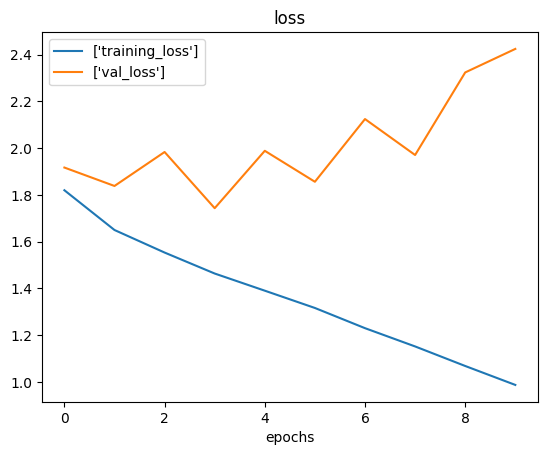

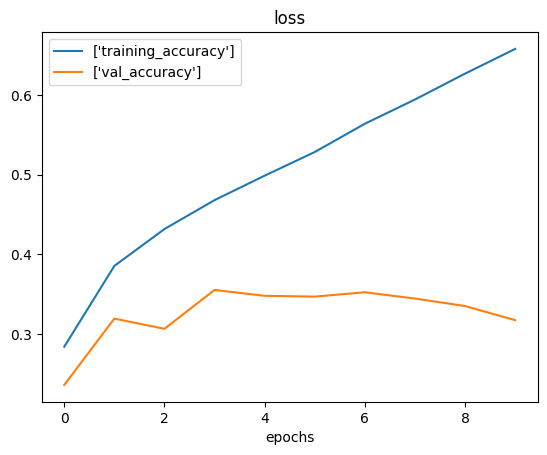

In [63]:
from helper_functions import plot_loss_curve
plot_loss_curve(history_fine_tuning)

## Confusion matrix

In [ ]:
from helper_functions import plot_confusion_matrix

# Create test labels and predictions
test_labels = []
for images, labels in test_data.unbatch():
  test_labels.append(tf.argmax(labels).numpy())
test_pred_probs = fine_tuning_model.predict(test_data)
test_predictions = tf.argmax(test_pred_probs, axis=1)

array([[0.37586207, 0.1137931 , 0.02413793, 0.10344828, 0.21724138,
        0.11724138, 0.04827586],
       [0.07241379, 0.56206897, 0.08275862, 0.09655172, 0.04827586,
        0.07241379, 0.06551724],
       [0.10344828, 0.09655172, 0.0862069 , 0.13793103, 0.31034483,
        0.2       , 0.06551724],
       [0.06206897, 0.09655172, 0.08275862, 0.38965517, 0.12413793,
        0.20689655, 0.03793103],
       [0.07931034, 0.17586207, 0.05862069, 0.15172414, 0.2862069 ,
        0.19655172, 0.05172414],
       [0.03793103, 0.04482759, 0.04482759, 0.16896552, 0.34827586,
        0.27241379, 0.08275862],
       [0.04482759, 0.08275862, 0.06551724, 0.19310345, 0.12068966,
        0.15862069, 0.33448276]])

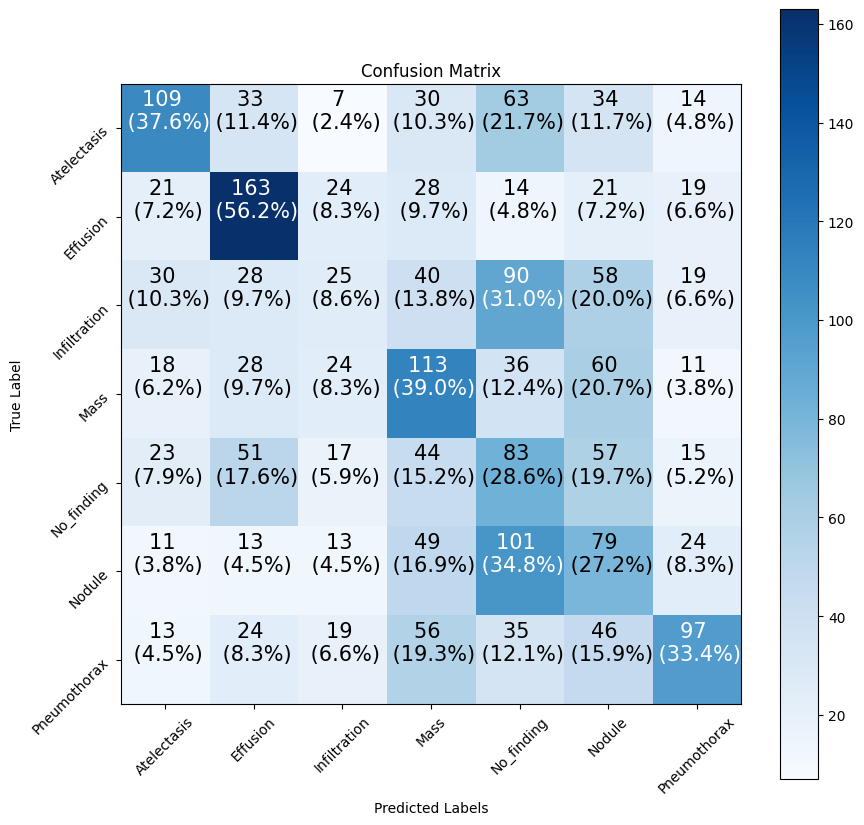

In [12]:
plot_confusion_matrix(test_labels, test_predictions, class_names)

# Results

We can already observe an improvement from the dense model. The model performs as follows:
* atelectasis: 52.4% of alectasis samples are predicted correctly.
* Effusion: 44.5% of effusion samples are predicted correctly, the model confuses it for Infiltration.
* Infiltration: 20% of infiltration samples are predicted correctly. Often confused for No findings.
* Mass: 25.5% of mass samples are predicted correctly. Confused many times for Atelectasis and Infiltration.
* No finding: 44.1% of No finding samples are predicted correctly. 
* Nodule: 3.1% of nodule examples are predicted correctly.The worst performing label. Confused many times for  No finding.
* Pneumothorax: 36.9% of No Pneumothorax samples are predicted correctly.